**Deep Learning and Neural Networks Coursework**

---



**Imports**

---

* Package imports for implementation of CNN for CIFAR10 dataset, including dataloading package *torchvision*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

print(device)

cuda:0


**Normalization**

---

* Transformation of torchvision datasets from [0,1] range to [-1,1] (normalized range)

* batch size default is 32, but stuck with 64 as a batch size for the majority of the model training


In [2]:
def get_datasets(batch_size = 32):
    # Define transformations for data augmentation
    augmentations = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(hue=.09, saturation=.09),
        transforms.RandomResizedCrop(size=(32, 32), antialias=True, scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333)),
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Define transformations for testing (without augmentation)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=augmentations)

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2)

    testset = torchvision.datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=transform)

    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck')

    return trainset, trainloader, testset, testloader, classes

In [7]:
trainset, trainloader, testset, testloader, classes = get_datasets(batch_size=64)

100%|██████████| 170498071/170498071 [00:03<00:00, 48947069.03it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Definition of CNN**


---

* used He initialization for weights to alleviate vanishing gradient problem when it comes to ReLU

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.act1 = nn.ReLU(inplace=True)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.act2 = nn.ReLU(inplace=True)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(2048, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

        # Weight initialization
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)

    def forward(self, x):

        x = self.avgpool1(self.act1(self.bn1(self.conv1(x))))
        x = self.avgpool2(self.act2(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

net = Net()

**Definition of Loss Function and Optimizer**

---


In [4]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

**CNN Training**

---



In [9]:
# evaluates current performance of model on test dataset
def evaluate_test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1) # highest energy (class)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    return correct / total

# evaluates current performance of model on training dataset
def evaluate_train(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1) # highest energy (class)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the training images: {100 * correct // total} %')
    return correct / total

In [17]:
# primary training function for model
def train_network(net, trainloader, epoch=None, max_epoch=10):

    # declaration of evaluation metrics
    eval = {
        "accuracy": [],
        "validation_accuracy": [],
        "loss": [],
        "epoch": []
    }

    if epoch is None:
      epoch = 0
    # else we are continuing to train from epoch > 0

    while True:  # loop over the dataset multiple times
        running_loss = 0.0
        info_length = 512
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print loss against epoch
            running_loss += loss.item()
            if i % info_length == (info_length-1):
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / info_length:.3f}')
                epoch_loss = running_loss
                running_loss = 0.0

        # per epoch, print metrics
        print(f"epoch {epoch} finished")
        eval["accuracy"].append(evaluate_test(net))
        eval["validation_accuracy"].append(evaluate_train(net))
        eval["loss"].append(epoch_loss/info_length)
        eval["epoch"].append(epoch)
        epoch += 1

        if epoch > max_epoch:
          break

    return eval

In [ ]:
net.to(device)

eval_64 = train_network(net, trainloader, max_epoch=10)

**Testing**

---

Functions modified from code in the PyTorch classification tutorial

* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [11]:
evaluate_test(net)
evaluate_train(net)

Accuracy of the network on the 10000 test images: 76 %
Accuracy of the network on the training images: 77 %


0.7748

**Visualisation**

---

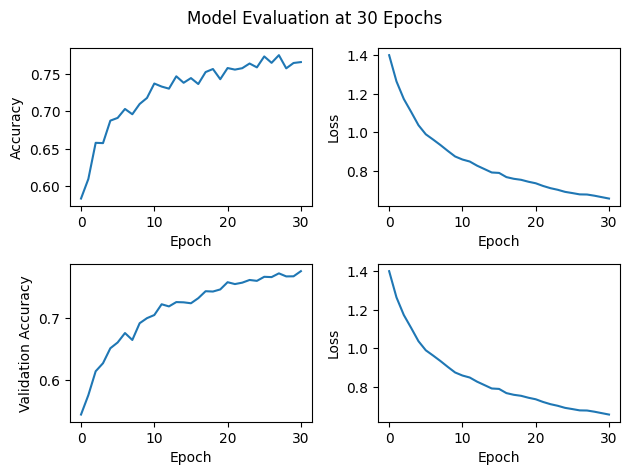

In [15]:
import matplotlib.pyplot as plt

f, axs = plt.subplots(2,2)

ax = axs[0,0]
ax.plot(eval_64["epoch"], eval_64["accuracy"], label="batch_size = 64")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")

ax = axs[0,1]
ax.plot(eval_64["epoch"], eval_64["loss"], label="batch_size = 64")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")

ax = axs[1,0]
ax.plot(eval_64["epoch"], eval_64["validation_accuracy"], label="batch_size = 64")
ax.set_ylabel("Validation Accuracy")
ax.set_xlabel("Epoch")

ax = axs[1,1]
ax.plot(eval_64["epoch"], eval_64["loss"], label="batch_size = 64")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")

f.suptitle("Model Evaluation at 30 Epochs")
f.tight_layout()